In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
np.random.seed(100)


In [3]:
df = pd.read_csv("healthcare-dataset-stroke-data.csv")

In [4]:
df.info()
# print(df.isnull().values.any())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [5]:
# df.drop(['id'], axis = 1, inplace = True)

In [6]:
print(f"Gender",df.gender.unique())
print(f"hypertension",df.hypertension.unique())
print(f"heart_disease",df.heart_disease.unique())
print(f"ever_married",df.ever_married.unique())
print(f"work_type",df.work_type.unique())
print(f"Residence_type",df.Residence_type.unique())
print(f"smoking_status",df.smoking_status.unique())

Gender ['Male' 'Female' 'Other']
hypertension [0 1]
heart_disease [1 0]
ever_married ['Yes' 'No']
work_type ['Private' 'Self-employed' 'Govt_job' 'children' 'Never_worked']
Residence_type ['Urban' 'Rural']
smoking_status ['formerly smoked' 'never smoked' 'smokes' 'Unknown']


It looks like there are only missing values for 'bmi' however by looking at the data we can see that there are values 'unknown' for 'smoking_status' which we should address

In [7]:
# Values for 'smoking_status' in training data
print(f"Never smoked: ",len(df[df['smoking_status'] == 'never smoked']))
print(f"Formerly smoked: ",len(df[df['smoking_status'] == 'formerly smoked']))
print(f"Smokes: ",len(df[df['smoking_status'] == 'smokes']))
print(f"Unknown: ",len(df[df['smoking_status'] == 'Unknown']))

Never smoked:  1892
Formerly smoked:  885
Smokes:  789
Unknown:  1544


In [8]:
df['smoking_status'] = df['smoking_status'].replace(['Unknown'], np.nan)

In [9]:
print(f"Unknown: ",len(df[df['smoking_status'] == 'Unknown']))

Unknown:  0


In [10]:
# check that the smoking_status=='Unknown' is addressed
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     3566 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [11]:
# print(df['gender'].value_counts())
print(df['stroke'].value_counts())

0    4861
1     249
Name: stroke, dtype: int64


In [12]:
df = df.dropna()
print(df.shape)
print(df['stroke'].value_counts())

(3426, 12)
0    3246
1     180
Name: stroke, dtype: int64


Below we can look at the relationships between different labels

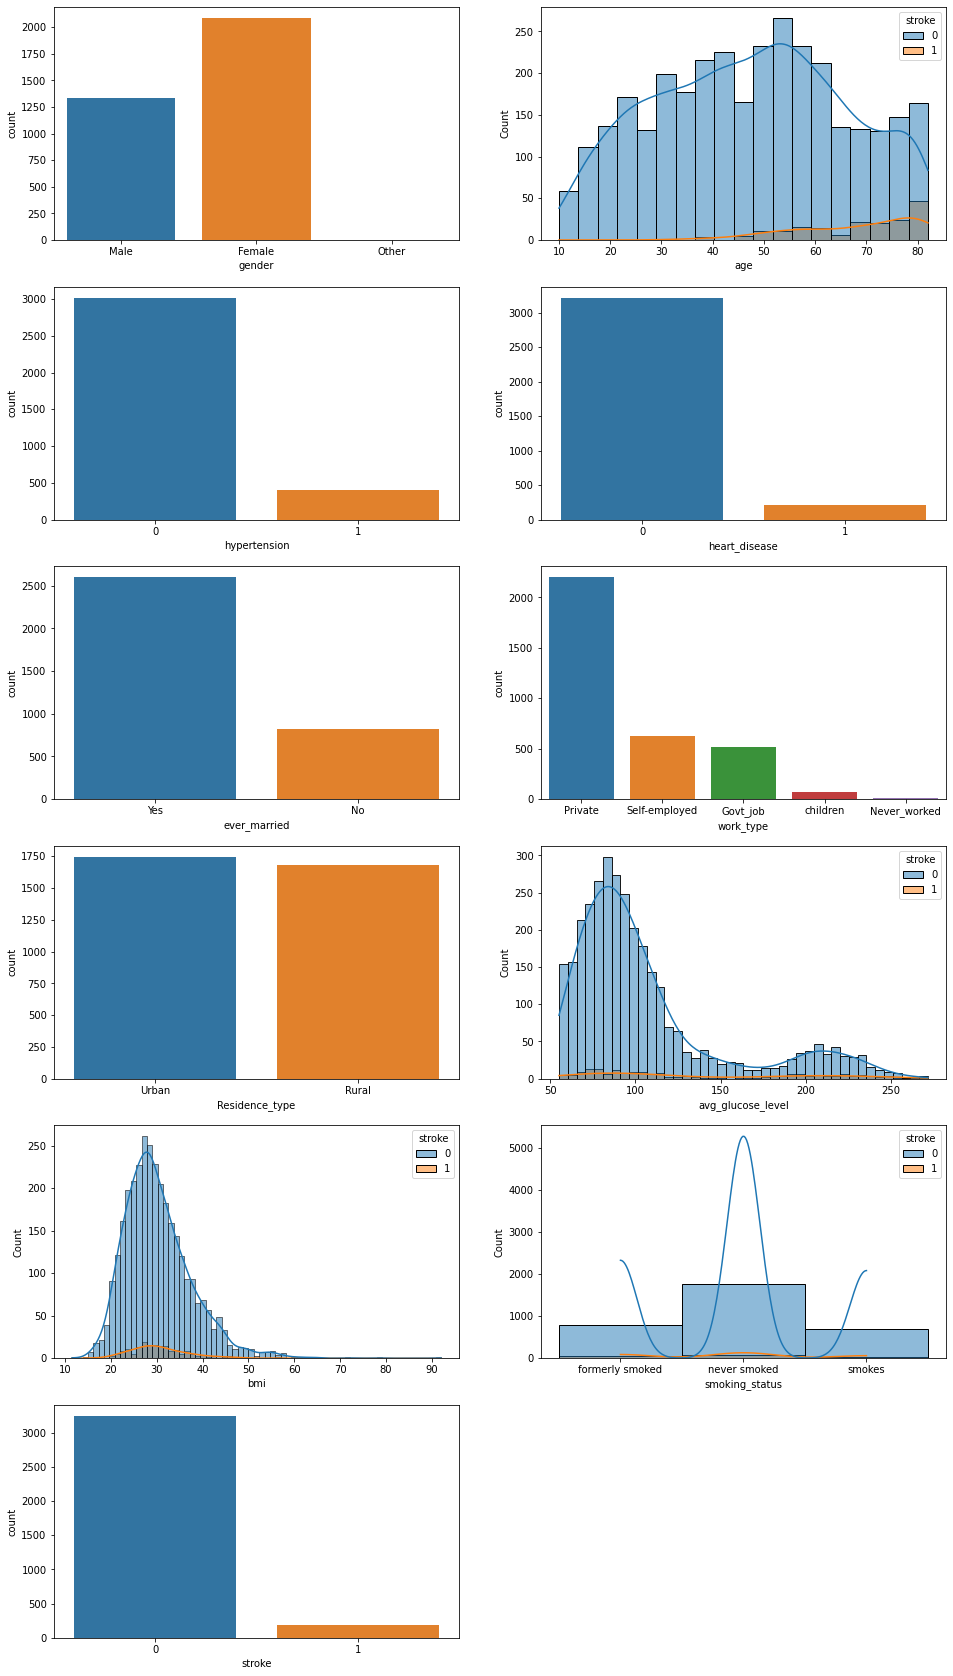

In [13]:
display=plt.figure(figsize=(16, 30))

for index, column in enumerate(list(df.columns.drop(['id']).values)):
    display.add_subplot(6, 2, index + 1)
    hist_types = ['avg_glucose_level', 'age', 'bmi', 'smoking_status']
    if column in hist_types:
        sns.histplot(data=df, x=column , kde=True, hue='stroke')
    else:
        sns.countplot(data=df, x=column)

plt.show()

Certain values are currently in the dataset as strings. We can convert these to one-hot encodings with corresponding values.

In [14]:
df = pd.get_dummies(df, columns=['smoking_status', 'gender', 'ever_married', 'Residence_type', 'work_type'])

In [15]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df = pd.DataFrame(scaler.fit_transform(df), columns = df.columns)

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3426 entries, 0 to 3425
Data columns (total 22 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              3426 non-null   float64
 1   age                             3426 non-null   float64
 2   hypertension                    3426 non-null   float64
 3   heart_disease                   3426 non-null   float64
 4   avg_glucose_level               3426 non-null   float64
 5   bmi                             3426 non-null   float64
 6   stroke                          3426 non-null   float64
 7   smoking_status_formerly smoked  3426 non-null   float64
 8   smoking_status_never smoked     3426 non-null   float64
 9   smoking_status_smokes           3426 non-null   float64
 10  gender_Female                   3426 non-null   float64
 11  gender_Male                     3426 non-null   float64
 12  gender_Other                    34

In the baseline, we remove all the 'Unknown' value for 'smoking_status'and all NaN values for 'bmi'. We will later see what the results look like when we introduce 'missingness' to this fully observed dataset.

Now let's split up the data into testing and training datasets. We will train a logistic regression model on this data without removing additional values.

In [17]:
train_data, test_data = train_test_split(df, test_size=0.2, random_state=25)

In [18]:
print(f"Number of training examples: {train_data.shape[0]}")
print(f"Number of testing examples: {test_data.shape[0]}")

Number of training examples: 2740
Number of testing examples: 686


To balance the classes, we will remove some of the data points that have stroke=0 and increase the data points where stroke=1 using sklearn's resample.

In [19]:
from sklearn.utils import resample
print(train_data['stroke'].value_counts())

#create two different dataframe of majority and minority class 
df_majority = train_data[(train_data['stroke']==0)] 
df_minority = train_data[(train_data['stroke']==1)] 
# upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,    # sample with replacement
                                #  n_samples= int(train_data['stroke'].value_counts()[0]), # to match majority class
                                 n_samples = 2000,
                                 random_state=0)  # reproducible results
# Combine majority class with upsampled minority class
train_data = pd.concat([df_minority_upsampled, df_majority])


print(train_data['stroke'].value_counts())

0.0    2594
1.0     146
Name: stroke, dtype: int64
0.0    2594
1.0    2000
Name: stroke, dtype: int64


In [20]:
train_data.head()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes,...,gender_Other,ever_married_No,ever_married_Yes,Residence_type_Rural,Residence_type_Urban,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children
75,0.620519,0.888889,0.0,0.0,0.814745,0.286957,1.0,1.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
31,0.016161,0.611111,0.0,0.0,0.074324,0.211180,1.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
142,0.798877,0.833333,1.0,0.0,0.865109,0.422360,1.0,1.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
175,0.143675,0.777778,0.0,0.0,0.098514,0.120497,1.0,1.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
141,0.882715,0.680556,0.0,0.0,0.671683,0.301863,1.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


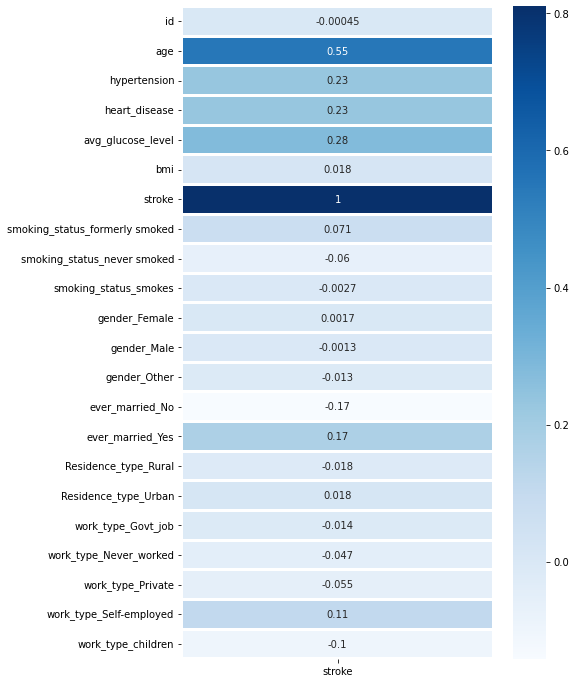

In [21]:
from matplotlib.colors import ListedColormap

cols = list(train_data.columns)
# print(cols)
corr_data = train_data.corr()

corr_data = np.asarray(train_data[cols].corr()['stroke'][:])
# print(corr_data.shape)
corr_data.reshape(22,1)
# print(corr_data.shape)

f, ax = plt.subplots(figsize=(7, 12))
# Generate a mask for upper traingle
# mask = np.triu(np.ones_like(corr_data, dtype=bool))

cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(corr_data[:, np.newaxis], annot=True,annot_kws={"size": 10}, linewidths=2,cmap='Blues', robust=True, xticklabels=["stroke"], yticklabels=cols)

In [22]:
from sklearn.linear_model import LogisticRegression
x_train = train_data.loc[:, train_data.columns != 'stroke']
y_train = train_data['stroke']

model = LogisticRegression(random_state=0).fit(x_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [23]:
y_pred = model.predict(x_train)
y_trainpred = y_pred
from sklearn.metrics import accuracy_score
print(f"Accuracy of model - full training: ", accuracy_score(y_pred, y_train))

Accuracy of model - full training:  0.761863299956465


In [24]:
x_test = test_data.loc[:, test_data.columns != 'stroke']
y_test = test_data['stroke']

y_pred = model.predict(x_test)
print(f"Accuracy of model - full test: ", accuracy_score(y_pred, y_test))

Accuracy of model - full test:  0.7434402332361516


In [25]:
from sklearn.metrics import confusion_matrix

confusion = confusion_matrix(y_test, y_pred)

print('Confusion Matrix\n')
print(confusion)
print("True positive rate: ", confusion[1][1]/(confusion[1][1]+confusion[0][1]))
print("True negative rate: ", confusion[0][0]/(confusion[0][0]+confusion[0][1]))

Confusion Matrix

[[489 163]
 [ 13  21]]
True positive rate:  0.11413043478260869
True negative rate:  0.75


After training the model on our training dataset, we can see that the baseline model produces an accuracy of 94.6%. Now, we will selectively remove values based on the correlation we found in our correlation computation.

Looking at the correlation data, we can see that there are a few labels with high correlation to 'stroke' prediction. We will randomly remove 1%, 5%, and 10% of these values to see how they affect model accuracy.

In [26]:
my_data = corr_data[:, np.newaxis]
type(my_data)
my_data = [arr.tolist() for arr in my_data]
my_data = [item for sublist in my_data for item in sublist]

d = sorted(my_data, reverse=True)[0:4]
# type(d[0])
print(d)
t = list(corr_data[:, np.newaxis])
names=[]
indicies = []
for i in range(1,4):
  temp = t.index(d[i])
  names.append(cols[temp])
  indicies.append(temp)

print(names)
print(indicies)



[1.0, 0.5479350309721465, 0.28134429598312183, 0.2329855603977625]
['age', 'avg_glucose_level', 'heart_disease']
[1, 4, 3]


In [27]:
test_data.head()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes,...,gender_Other,ever_married_No,ever_married_Yes,Residence_type_Rural,Residence_type_Urban,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children
1213,0.344002,0.944444,1.0,0.0,0.168544,0.273292,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
3285,0.559405,0.444444,0.0,0.0,0.037623,0.192547,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1087,0.331370,0.944444,0.0,0.0,0.150402,0.224845,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
1235,0.248452,0.041667,0.0,0.0,0.204598,0.118012,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2850,0.868435,0.305556,0.0,0.0,0.254870,0.155280,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


In [28]:
import random

percent_removed = 0.1

num_removed = int(np.round(percent_removed*len(train_data)))
# print(num_removed)

smalltest = train_data

# print(type(num_removed))
remove = random.sample(range(len(train_data)), num_removed)
print(len(remove))
# first = smalltest.iloc[remove,indicies]
# print(first)
smalltest.iloc[remove,indicies] = np.nan

459


In [29]:
# smalltest.iloc[remove,indicies] = np.nan

In [30]:
# print(smalltest.iloc[[0,1,2],indicies])

In [31]:
smalltest.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4594 entries, 75 to 1156
Data columns (total 22 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              4594 non-null   float64
 1   age                             4135 non-null   float64
 2   hypertension                    4594 non-null   float64
 3   heart_disease                   4135 non-null   float64
 4   avg_glucose_level               4135 non-null   float64
 5   bmi                             4594 non-null   float64
 6   stroke                          4594 non-null   float64
 7   smoking_status_formerly smoked  4594 non-null   float64
 8   smoking_status_never smoked     4594 non-null   float64
 9   smoking_status_smokes           4594 non-null   float64
 10  gender_Female                   4594 non-null   float64
 11  gender_Male                     4594 non-null   float64
 12  gender_Other                    4

Here we will decide what to do with the missing data. 
1. smalltest.dropna() will drop all rows with missing values.
2. smalltest.fillna(smalltest.mean()) will take the average value of the column of the missing value and replace the missing value with this
3. KNNImputer will find the k-nearest neighbors and replace the missing value with this

In [32]:
# smalltest = smalltest.dropna()

In [33]:
# smalltest.fillna(smalltest.mean())
# for i in names:
#   smalltest[i] = smalltest[i].fillna(smalltest[i].mean())


In [34]:
from sklearn.impute import KNNImputer
# here k=3
print(smalltest.shape)

imputer = KNNImputer(n_neighbors=3)
smalltest = pd.DataFrame(imputer.fit_transform(smalltest),columns = smalltest.columns)

print(smalltest.shape)
print(smalltest.isna().any())

(4594, 22)
(4594, 22)
id                                False
age                               False
hypertension                      False
heart_disease                     False
avg_glucose_level                 False
bmi                               False
stroke                            False
smoking_status_formerly smoked    False
smoking_status_never smoked       False
smoking_status_smokes             False
gender_Female                     False
gender_Male                       False
gender_Other                      False
ever_married_No                   False
ever_married_Yes                  False
Residence_type_Rural              False
Residence_type_Urban              False
work_type_Govt_job                False
work_type_Never_worked            False
work_type_Private                 False
work_type_Self-employed           False
work_type_children                False
dtype: bool


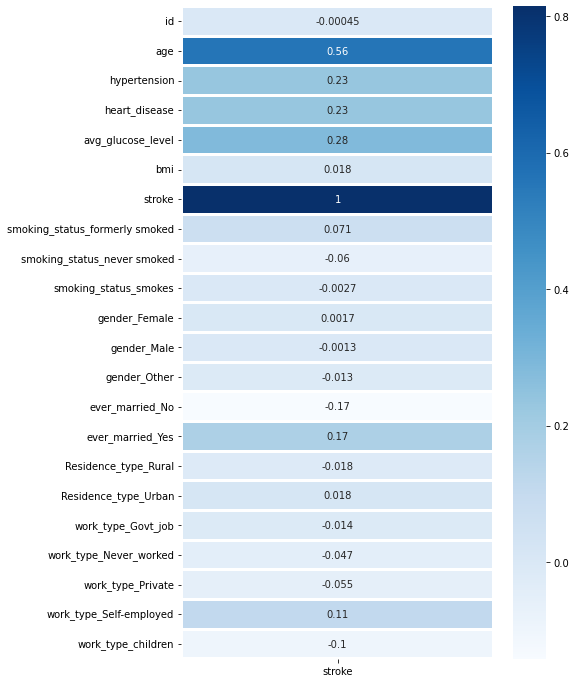

In [35]:
# from matplotlib.colors import ListedColormap

cols = list(smalltest.columns)
# print(cols)
corr_data = smalltest.corr()

corr_data = np.asarray(smalltest[cols].corr()['stroke'][:])
# print(corr_data.shape)
corr_data.reshape(22,1)
# print(corr_data.shape)

f, ax = plt.subplots(figsize=(7, 12))
# Generate a mask for upper traingle
# mask = np.triu(np.ones_like(corr_data, dtype=bool))

cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(corr_data[:, np.newaxis], annot=True,annot_kws={"size": 10}, linewidths=2,cmap='Blues', robust=True, xticklabels=["stroke"], yticklabels=cols)

In [36]:
my_data = corr_data[:, np.newaxis]
type(my_data)
my_data = [arr.tolist() for arr in my_data]
my_data = [item for sublist in my_data for item in sublist]

d = sorted(my_data, reverse=True)[0:4]
# type(d[0])
print(d)
t = list(corr_data[:, np.newaxis])
names=[]
indicies = []
for i in range(1,4):
  temp = t.index(d[i])
  names.append(cols[temp])
  indicies.append(temp)

print(names)
print(indicies)


[1.0, 0.5573850017272092, 0.28456565313255683, 0.2329722121014695]
['age', 'avg_glucose_level', 'heart_disease']
[1, 4, 3]


In [37]:
# from sklearn.linear_model import LogisticRegression
x = smalltest.loc[:, smalltest.columns != 'stroke']
y = smalltest['stroke']

model = LogisticRegression(random_state=0, max_iter=9000).fit(x, y)

In [38]:
y_pred = model.predict(x)
y_trainpred = y_pred
from sklearn.metrics import accuracy_score
print(f"Accuracy of corrupted model - missing train: ", accuracy_score(y_pred, y))


Accuracy of corrupted model - missing train:  0.7677405311275577


In [39]:
x_test = test_data.loc[:, test_data.columns != 'stroke']
y_test = test_data['stroke']

y_pred = model.predict(x_test)
print(f"Accuracy of corrupted model - full test: ", accuracy_score(y_pred, y_test))

Accuracy of corrupted model - full test:  0.7376093294460642


In [40]:
confusion = confusion_matrix(y_test, y_pred)
print('Confusion Matrix\n')
print(confusion)
print("True positive rate: ", confusion[1][1]/(confusion[1][1]+confusion[0][1]))
print("True negative rate: ", confusion[0][0]/(confusion[0][0]+confusion[0][1]))


Confusion Matrix

[[485 167]
 [ 13  21]]
True positive rate:  0.11170212765957446
True negative rate:  0.7438650306748467
